# Estimating European Option Price Using Amplitude Estimation

## Introduction and background


In Finance models we are often interested in calculating the average of a function of a given probability distribution ($E[f(x)]$). The most popular method to estimate the average is Monte Carlo [[1](#MCMF)] due to its flexibility and ability to generically handle stochastic parameters.
Classical Monte Carlo methods, however, generally require extensive computational resources to provide an accurate estimation.
By leveraging the laws of quantum mechanics, a quantum computer may provide novel ways to solve computationally intensive financial problems, such as risk management, portfolio optimization, and option pricing.
The core quantum advantage of several of these applications is the Amplitude Estimation algorithm [[2](#AEA)] which can estimate a parameter with a
convergence rate of $\Omega(1/M^{1/2})$, compared to $\Omega(1/M)$ in the classical case, where $M$ is the number of Grover iterations in the quantum case and the number of the Monte Carlo samples in the classical case. This represents a theoretical quadratic speed-up of the quantum method over classical Monte Carlo methods.

### Option pricing

An option is the possibility to buy (call) or sell (put) an item (or share) at a known price - the strike price (K), where the option has a maturity price (S).
The payoff function to describe for example a European call option will be:

$f(S)=\
\Bigg\{\begin{array}{lr}
    0, & \text{when } K\geq S\\
    S - K, & \text{when } K < S\end{array}
$

The maturity price is unknown. Therefore, it is expressed by a price distribution function, which may be any type of a distribution function.
For example a log-normal distribution: $\mathcal{ln}(S)\sim~\mathcal{N}(\mu,\sigma)$,
where $\mathcal{N}(\mu,\sigma)$ is the standard normal distribution with mean equal to $\mu$ and standard deviation equal to $\sigma$ .

To estimate the average option price using a quantum computer, one needs to:

- Load the distribution, that is, discretize the distribution using $2^n$ points (n is the number of qubits) and truncate it.

- Implement the payoff function that is equal to zero if $S\leq{K}$ and increases linearly otherwise.
  The linear part is approximated in order to be loaded properly using $R_y$ rotations [[3](#QAR)].

- Evaluate the expected payoff using amplitude estimation.

The algorithmic framework is called Quantum Monte-Carlo Integration. For a basic example, see [QMCI](https://github.com/Classiq/classiq-library/blob/main/algorithms/amplitude_estimation/qmc_user_defined/qmc_user_defined.ipynb]).
Here we use the same framework to estimate european call option, where the underlying asset distribution at the maturity data is modeled as log-normal distribution.

## Designing The Quantum Algorithm

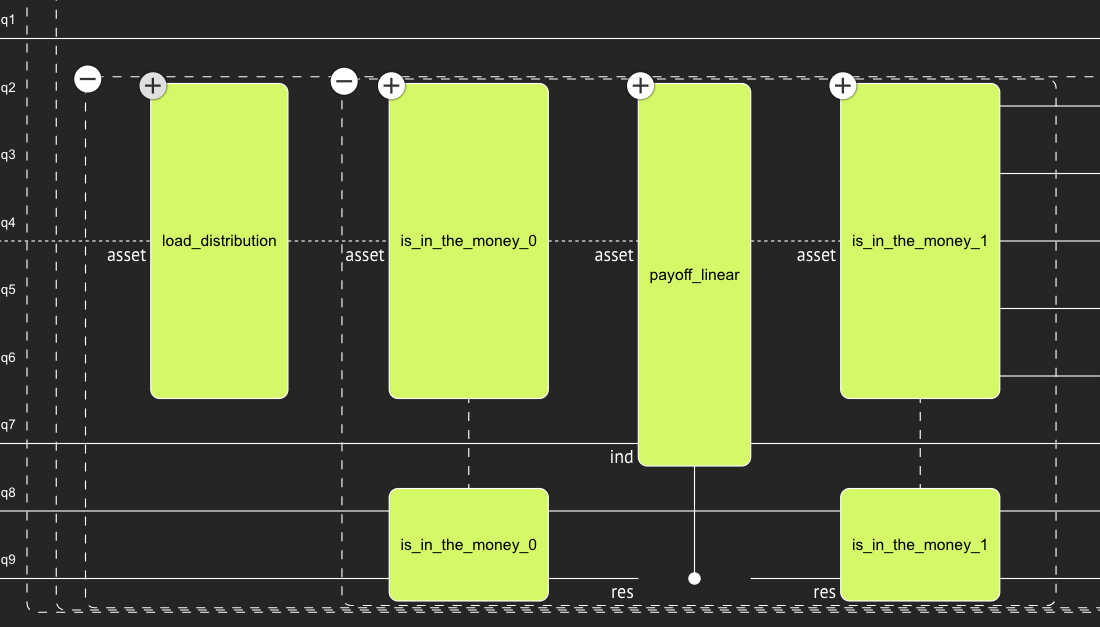

### The probability distribution

We begin by creating the probability distribution. The distribution is describing the option underlying asset price at maturity date. We will load a discrete version of the log normal probability with $2^n$ points, when $\mu$ is equal to `mu`, $\sigma$ is equal to `sigma` and $n$ is equal to `num_qubits`.

We also choose here `K`, the strike price.

In [1]:
num_qubits = 5
mu = 0.7
sigma = 0.13

K = 1.9

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy


def get_log_normal_probabilities(mu, sigma, num_points):
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    # cut the distribution 3 sigmas from the mean
    low = np.maximum(0, mean - 3 * stddev)
    high = mean + 3 * stddev
    print(mean, variance, stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma, scale=np.exp(mu))

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


Text(0.5, 1.0, 'Probability and Payoff vs. Asset Value')

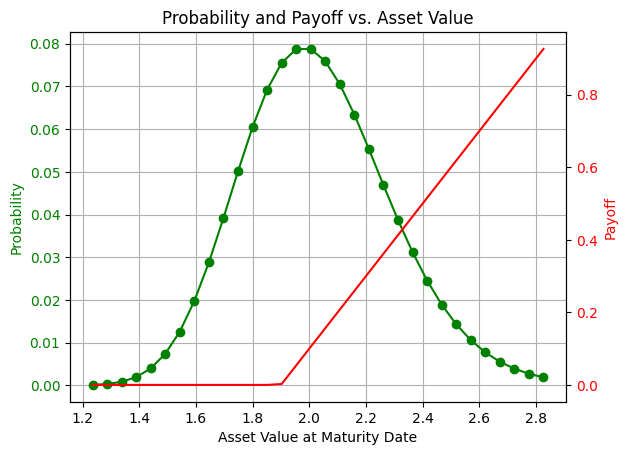

In [3]:
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)
# normalize the probabilities
probs = probs / np.sum(probs)

fig, ax1 = plt.subplots()

# Plot the probabilities
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value at Maturity Date")
ax1.set_ylabel("Probability", color="g")

# Create a second y-axis for the payoff
ax2 = ax1.twinx()
ax2.plot(grid_points, np.maximum(grid_points - K, 0), "r-", label="Payoff")  # Red line
ax2.set_ylabel("Payoff", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Add grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

#### Quantum function for the distribution loading

Here we use the general `inplace_prepare_state` function. The `inplace` is needed as it needs to be applied over and over again on the same quantum variable.

We use the genreal purpose state preparation for simplicity. There are more efficient and scalable methods for preparing the required distribution, for example see [[4](#GS)].

In [4]:
from classiq import *


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probabilities=probs.tolist(), bound=0, target=asset)

### The payoff function

We continue with creating the payoff function . We want to load $U_{payoff}|S\rangle|0\rangle = \sqrt{f_{payoff}(S)}|S\rangle|1\rangle + \sqrt{1-f_{payoff}(S)}|S\rangle|0\rangle$.

Here, to build the European call option function, we will do nothing if the strike price is smaller than $K$, otherwise we apply a linear amplitude loading.

*Note: in order to save qubits and depth, the register $|S\rangle_n$ will hold a value in the range $[0, 2^{n-1}]$, "labeling" the asset value. The mapping to the asset value space will occur within the comparator and amplitude loading, using the the following (classical) `scale` function*

In [10]:
from classiq.qmod.symbolic import ceiling

grid_step = (max(grid_points) - min(grid_points)) / (len(grid_points) - 1)


# translate from qubit space to price space
def scale(val: QNum):
    return val * grid_step + min(grid_points)


# translate from price space to qubit space
def descale(val: int):
    return (val - min(grid_points)) / grid_step


@qfunc
def payoff(asset: QNum, ind: QBit):
    aux = QBit("aux")
    # check if asset price is 'in the money' - crossed the strike price
    within_apply(
        lambda: assign(asset >= ceiling(descale(K)), aux),
        lambda: control(aux, lambda: payoff_linear(asset, ind)),
    )

Here, for simplicity, we use a general purpose amplitude loading method using the `*=` syntax. The calculation is exact, however not scalable for large variable sizes.

There are more scalable methods, like the ones mentioned in [[4](#GS)], [[6](#RAINBOW)].

*Important: In order that all loaded amplitudes will not be greater than 1, we have to normalize the payoff by `scaling_factor`, later to be multiplied in the post-process stage.*

In [11]:
from classiq.qmod.symbolic import abs, sqrt

scaling_factor = max(grid_points) - K


class OptionPricingState(QStruct):
    asset: QNum[num_qubits, False, 0]
    ind: QBit


@qfunc
def payoff_linear(asset: QNum, ind: QBit):
    ind *= sqrt(abs((scale(asset) - K) / scaling_factor))


@qfunc
def european_call_state_preparation(state: OptionPricingState):
    load_distribution(state.asset)
    payoff(state.asset, state.ind)

### Wrapping to an Amplitude Estimation model

After defining the probability distribution and the payoff function, we pack it into a `grover_operator`. They are both used as the state preparation part of the grover operator, while the oracle is very simple and will only need to recognize whether the indicator qubit is in the $|1\rangle$ state.

The grover operator is then integrated within the [Iterative Quantum Amplitude Estimation algorithm](https://github.com/Classiq/classiq-library/blob/main/algorithms/amplitude_estimation/quantum_counting/quantum_counting.ipynb) [[5](#IQAE)] for the estimation of the amplitude of the state:
$$
|\Psi\rangle = \sum_x|x\rangle[\sqrt{p(x)f(x)}|1\rangle_{ind} + \sqrt{p(x)(1-f(x))}|0\rangle_{ind}] = a|\Psi_1\rangle + \sqrt{1-a^2}|\Psi_0\rangle
$$
Which approximates the expectation value of the payoff:
$$
a = \sum_xp(x)f(x) \approx E[f]_p
$$

In [12]:
@qfunc
def iqae_algorithm(
    k: CInt,
    oracle_operand: QCallable[QArray[QBit]],
    sp_operand: QCallable[QArray[QBit]],
    x: QArray[QBit],
):
    sp_operand(x)
    power(k, lambda: grover_operator(oracle_operand, sp_operand, x))


@qfunc
def iqae_oracle(state: OptionPricingState):
    Z(state.ind)


@qfunc
def main(
    k: CInt,
    ind: Output[QBit],
) -> None:
    state = OptionPricingState("state")
    asset = QArray("asset")
    allocate(state.size, state)
    iqae_algorithm(
        k,
        iqae_oracle,
        european_call_state_preparation,
        state,
    )
    bind(state, [asset, ind])

Finally, we define the parameters for the accuracy of the amplitude estimation. This will affect the expected number of grover of repetitions within the execution:

In [13]:
@cfunc
def cmain():
    iqae_res = iqae(
        epsilon=0.05, alpha=0.01  # desired error  # desired probability for error
    )
    save({"iqae_res": iqae_res})

## Quantum program synthesis

After we finished the model design, we synthesize the model to a quantum program.

In [14]:
qmod = create_model(
    main,
    constraints=Constraints(max_width=20),
    classical_execution_function=cmain,
    out_file="option_pricing",
)
write_qmod(qmod, "option_pricing", decimal_precision=10)

In [15]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/8d3aaafa-a271-4384-8588-1e9499bf8cf7?version=0.64.0.dev0


## Quantum Program Execution

In [16]:
result_iqae = execute(qprog).result_value()

#### Post processing
In order to get the expected payoff, we need to descale the measured amplitude by `scaling_factor`.

In [17]:
measured_payoff = result_iqae.estimation * scaling_factor
confidence_interval = np.array(result_iqae.confidence_interval) * scaling_factor

print("Measured Payoff:", measured_payoff)
print("Confidence Interval:", confidence_interval)

Measured Payoff: 0.17567552705951653
Confidence Interval: [0.17237516 0.17897589]


### Compare to the expected calculated payoff

In [18]:
expected_payoff = sum((grid_points - K) * (grid_points >= K) * probs)
print("Expected Payoff:", expected_payoff)

Expected Payoff: 0.17680663493930157


In [19]:
assert np.isclose(
    measured_payoff,
    expected_payoff,
    atol=10 * (confidence_interval[1] - confidence_interval[0]),
)

## References

<a name='MCMF'>[1]</a>: [Paul Glasserman, Monte Carlo Methods in Financial Engineering. Springer-Verlag New York, 2003, p. 596.](https://link.springer.com/book/10.1007/978-0-387-21617-1)

<br><a name='AEA'>[2]</a>: [Gilles Brassard, Peter Hoyer, Michele Mosca, and Alain Tapp, Quantum Amplitude Amplification and Estimation. Contemporary Mathematics 305 (2002)](https://arxiv.org/abs/quant-ph/0005055)

<br><a name='QAR'>[3]</a>: [ Nikitas Stamatopoulos, Daniel J. Egger, Yue Sun, Christa Zoufal, Raban Iten, Ning Shen, and Stefan Woerner, Option Pricing using Quantum Computers, Quantum 4, 291 (2020).
](https://arxiv.org/abs/1905.02666v5)

<br><a name='GS'>[4]</a>: [ Chakrabarti, Shouvanik, et al. "A threshold for quantum advantage in derivative pricing." Quantum 5 (2021): 463.](https://quantum-journal.org/papers/q-2021-06-01-463/)

<br><a name='IQAE'>[5]</a>: [Grinko, D., Gacon, J., Zoufal, C. et al. Iterative quantum amplitude estimation. npj Quantum Inf 7, 52 (2021)](https://doi.org/10.1038/s41534-021-00379-1)

<br><a name='RAINBOW'>[6]</a>: [Francesca Cibrario et al., Quantum Amplitude Loading for Rainbow Options Pricing. Preprint](https://arxiv.org/abs/2402.05574v2)